In [1]:

# Jiayang Jiang
# z5319476

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# read dataset and replace -200 by NaN
dataset = pd.read_excel("AirQualityUCI _ Students.xlsx")
dataset.replace(-200, np.nan, inplace=True)

# data pre-processing
# preprocess my dataset, convert date and time to year month day hour
def trans_Datetime(dataset):
    dataset_time = dataset.copy()
    # convert 'Date' to timestamp directly
    dataset_time['Date'] = pd.to_datetime(dataset_time['Date']).view('int64') // 10**9
    
    # convert 'Time' to seconds since midnight
    dataset_time['Time'] = pd.to_datetime(dataset_time['Time'], format='%H:%M:%S').dt.hour * 3600 \
                         + pd.to_datetime(dataset_time['Time'], format='%H:%M:%S').dt.minute * 60 \
                         + pd.to_datetime(dataset_time['Time'], format='%H:%M:%S').dt.second
                         
    dataset_time['DateTime_numeric'] = dataset_time['Date'] + dataset_time['Time']
    dataset_time['datetime'] = pd.to_datetime(dataset_time['DateTime_numeric'], unit='s')

    # convert datatime to year month day hour
    dataset_time['year'] = dataset_time['datetime'].dt.year
    dataset_time['month'] = dataset_time['datetime'].dt.month
    dataset_time['day'] = dataset_time['datetime'].dt.day
    dataset_time['hour'] = dataset_time['datetime'].dt.hour
    
    return dataset_time

# simply delete the miss value
def deletion_pre(dataset):
    dataset_de = dataset.copy()
    # drop the column which contains too many miss values
    dataset_de = dataset_de.drop(['NMHC(GT)'],axis=1)
    # drop miss value
    dataset_de.dropna(inplace=True)
    dataset_de = trans_Datetime(dataset_de)
    
    dataset_de.drop(['Date','Time','DateTime_numeric','datetime'],axis=1, inplace=True)
   
    return dataset_de

# use fillforward and mean to fill the miss value
def imputation_pre(dataset):
    dataset_im = dataset.copy()
    
    # fillforward to fill data and time if there are miss values
    dataset_im['Date'].fillna(method='ffill', inplace=True)
    dataset_im['Time'].fillna(method='ffill', inplace=True)
    
    dataset_im = trans_Datetime(dataset_im)
    dataset_im = dataset_im.drop(['NMHC(GT)'],axis=1)
    dataset_im.drop(['Date', 'Time', 'DateTime_numeric', 'datetime'], axis=1, inplace=True)
    # use mean to fill miss value
    dataset_im.fillna(dataset_im.mean(), inplace=True)

    return dataset_im

ImportError: Traceback (most recent call last):
  File "e:\python3.10\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 62, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: 页面文件太小，无法完成操作。


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [18]:
dataset_de = deletion_pre(dataset)
dataset_im = imputation_pre(dataset)

scaler = StandardScaler()

# split dataset to train, test set for classification
def split_set_classify(dataset):
    # calculate the mean
    co_mean = sum(dataset['CO(GT)'])/len(dataset['CO(GT)'])
    # co_mean = dataset['CO(GT)'].mean()

    X = dataset.drop(['CO(GT)'], axis=1)
    # binary target: 1 if CO(GT) > mean, 0 otherwise
    y = (dataset['CO(GT)'] > co_mean).astype(int)  

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # standardize the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# split dataset to train, test set for regression
def split_set_reg(dataset):
    X_reg = dataset.drop(['NOx(GT)'], axis=1)
    y_reg = dataset['NOx(GT)']
    

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
    
    # standardize the data
    X_train_scaled_reg = scaler.fit_transform(X_train_reg)
    X_test_scaled_reg = scaler.transform(X_test_reg)
    
    return X_train_scaled_reg, X_test_scaled_reg, y_train_reg, y_test_reg

In [19]:
# plot Loss and accuracy picture for classification
def plot_pic_class(history):
    plt.figure(figsize=(12, 6))
 
    plt.subplot(1, 2, 1)
    # loss
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Plot for the Classification Task')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # accuracy
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Plot for the Classification Task')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.show()
    
# Loss and estimated NOx(GT) plots for regression task
def plot_pic_reg(history,model, X_test_scaled_re, y_test_reg):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    # loss 
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    y_pred = model.predict(X_test_scaled_re)
    plt.subplot(1, 2, 2)
    # estimated NOx(GT
    plt.plot(y_test_reg.values, label='Actual NOx(GT)', alpha=0.6)
    plt.plot(y_pred, label='Predicted NOx(GT)', alpha=0.6)
    plt.xlabel('Sample Index')
    plt.ylabel('NOx(GT) Value')
    plt.title('MLP Validation Phase - Actual vs Estimate NOx(GT) Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return y_pred


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Confusion matrix and accuracy and precision tables for classification task
def model_performance(X_test,y_test,model):

    y_pred_prob = model.predict(X_test)
    # Convert probabilities to classes (assuming threshold of 0.5)
    y_pred = (y_pred_prob > 0.5).astype(int)
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    confusion_data = {
    'Confusion Matrix': ['Positive (Predicted)','Negative (Predicted)'],
    'Positive (Actual)': [TP,FP],
    'Negative (Actual)':[FN,TN],
    }
    confusion_data_df = pd.DataFrame(confusion_data)
    print('Table 2: Confusion matrix for the test data for the classification task.')
    print(confusion_data_df.to_string(index=False))
    print()
    
    # Compute accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    num_samples = len(y_test)
    accuracy_data = {
    '': ['CO(GT) classification'],
    'Accuracy': [round(accuracy,3)],
    'Precision':[round(precision,3)],
    'Number of Samples' : [num_samples]
    }
    accuracy_data_df = pd.DataFrame(accuracy_data)
    print('Table 3: Accuracy and precision for the test data for the classification task.')
    print(accuracy_data_df.to_string(index=False))
    
    
# Performance indexes table for regression task
def reg_performance(y_test_re,y_pred):
    # calculate rmse and mae
    rmse = np.sqrt(mean_squared_error(y_test_re, y_pred))
    mae = mean_absolute_error(y_test_re, y_pred)
    num_samples = len(y_test_re)
    reg_data = {
    'RMSE': [round(rmse,2)],
    'MAE': [round(mae,2)],
    'Number of Samples':[num_samples],
    }
    reg_data_df = pd.DataFrame(reg_data)
    print('Table 4: Result table for the test data for the regression task.')
    print(reg_data_df.to_string(index=False))

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# create model for classification
def create_model(X_train_scaled,X_test_scaled,y_train,y_test):
    model_class = Sequential([
        Dense(28, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.2),
        Dense(13, activation='relu'),
        Dropout(0.2),
        Dense(1,activation='sigmoid')  # Sigmoid activation for binary classification
    ])

    optimizer = Adam(learning_rate=0.004)

    # Compile the model
    model_class.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # train
    history_class = model_class.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                            validation_data=(X_test_scaled, y_test))

    loss_class, accuracy_class = model_class.evaluate(X_test_scaled, y_test)
    print(f'Test loss: {loss_class:.4f}, Test accuracy: {accuracy_class:.4f}')
    model_class.summary()
    
    return model_class,history_class

# create model for regression
def create_model_reg(X_train_scaled,X_test_scaled,y_train,y_test):
    reg_model = Sequential([
        Dense(26, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    # Compile the model
    reg_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    # train
    history_reg = reg_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
                                validation_data=(X_test_scaled, y_test))
    reg_model.summary()
    return reg_model,history_reg


In [22]:
# deletion dataset for classification

X_train_scaled_de = split_set_classify(dataset_de)[0]
X_test_scaled_de = split_set_classify(dataset_de)[1]
y_train_de = split_set_classify(dataset_de)[2]
y_test_de = split_set_classify(dataset_de)[3]

result_class_de = create_model(X_train_scaled_de,X_test_scaled_de,y_train_de,y_test_de)
model_class_de = result_class_de[0]
history_class_de = result_class_de[1]


Epoch 1/100
152/152 [==============================] - 1s 2ms/step - loss: 0.2776 - accuracy: 0.8886 - val_loss: 0.1957 - val_accuracy: 0.9209
Epoch 2/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2043 - accuracy: 0.9238 - val_loss: 0.1897 - val_accuracy: 0.9234
Epoch 3/100
152/152 [==============================] - 0s 1ms/step - loss: 0.1928 - accuracy: 0.9256 - val_loss: 0.1804 - val_accuracy: 0.9275
Epoch 4/100
152/152 [==============================] - 0s 1ms/step - loss: 0.1836 - accuracy: 0.9316 - val_loss: 0.1694 - val_accuracy: 0.9333
Epoch 5/100
152/152 [==============================] - 0s 1ms/step - loss: 0.1839 - accuracy: 0.9304 - val_loss: 0.1696 - val_accuracy: 0.9333
Epoch 6/100
152/152 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.9300 - val_loss: 0.1707 - val_accuracy: 0.9366
Epoch 7/100
152/152 [==============================] - 0s 1ms/step - loss: 0.1764 - accuracy: 0.9310 - val_loss: 0.1686 - val_accuracy: 0.9325

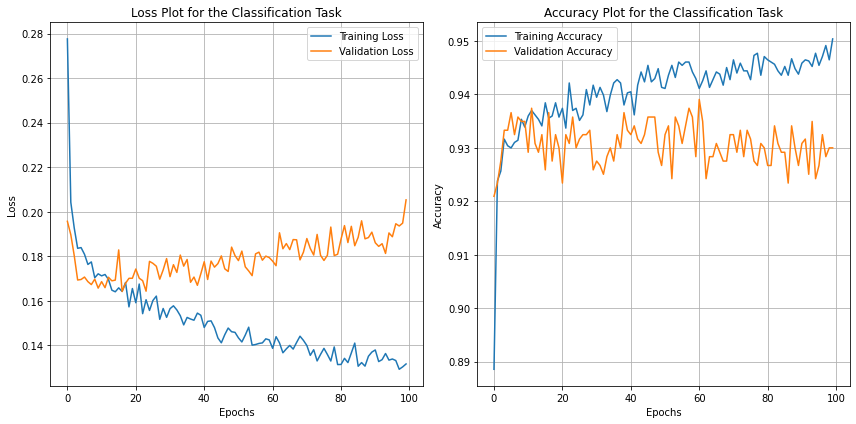

38/38 [==============================] - 0s 782us/step
Table 2: Confusion matrix for the test data for the classification task.
    Confusion Matrix  Positive (Actual)  Negative (Actual)
Positive (Predicted)                461                 30
Negative (Predicted)                 55                668

Table 3: Accuracy and precision for the test data for the classification task.
                       Accuracy  Precision  Number of Samples
CO(GT) classification      0.93      0.893               1214


In [35]:
# plot and performance
plot_pic_class(history_class_de.history)
model_performance(X_test_scaled_de, y_test_de, model_class_de)

In [24]:
# imputation dataset for classification
X_train_scaled = split_set_classify(dataset_im)[0]
X_test_scaled = split_set_classify(dataset_im)[1]
y_train = split_set_classify(dataset_im)[2]
y_test = split_set_classify(dataset_im)[3]

result_class_im = create_model(X_train_scaled,X_test_scaled,y_train,y_test)

model_im_class = result_class_im[0]
history_class_im = result_class_im[1]


Epoch 1/100
209/209 [==============================] - 1s 1ms/step - loss: 0.3437 - accuracy: 0.8527 - val_loss: 0.2673 - val_accuracy: 0.8786
Epoch 2/100
209/209 [==============================] - 0s 979us/step - loss: 0.2778 - accuracy: 0.8802 - val_loss: 0.2538 - val_accuracy: 0.8894
Epoch 3/100
209/209 [==============================] - 0s 978us/step - loss: 0.2593 - accuracy: 0.8931 - val_loss: 0.2450 - val_accuracy: 0.8965
Epoch 4/100
209/209 [==============================] - 0s 976us/step - loss: 0.2450 - accuracy: 0.9007 - val_loss: 0.2349 - val_accuracy: 0.9061
Epoch 5/100
209/209 [==============================] - 0s 976us/step - loss: 0.2395 - accuracy: 0.9074 - val_loss: 0.2244 - val_accuracy: 0.9025
Epoch 6/100
209/209 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.9044 - val_loss: 0.2257 - val_accuracy: 0.9049
Epoch 7/100
209/209 [==============================] - 0s 984us/step - loss: 0.2243 - accuracy: 0.9116 - val_loss: 0.2166 - val_accura

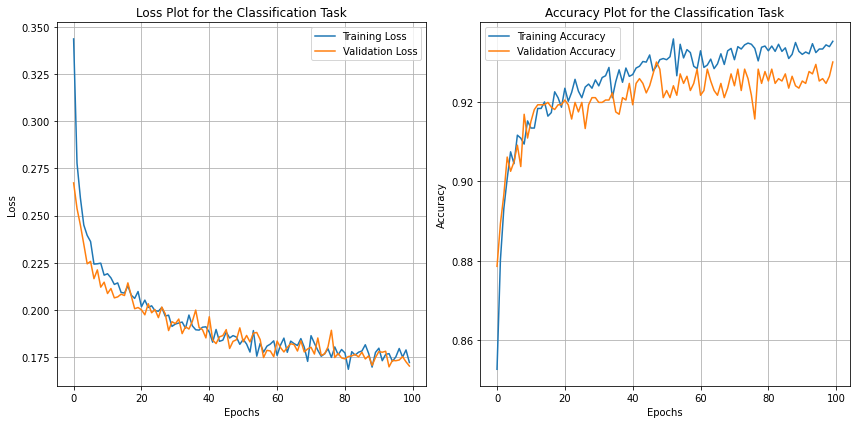

53/53 [==============================] - 0s 595us/step
Table 2: Confusion matrix for the test data for the classification task.
    Confusion Matrix  Positive (Actual)  Negative (Actual)
Positive (Predicted)                504                 76
Negative (Predicted)                 41               1051

Table 3: Accuracy and precision for the test data for the classification task.
                       Accuracy  Precision  Number of Samples
CO(GT) classification      0.93      0.925               1672


In [25]:
# plot and performance
plot_pic_class(history_class_im.history)
model_performance(X_test_scaled, y_test, model_im_class)

In [26]:
# deletion dataset for regression
X_train_scaled_reg_de = split_set_reg(dataset_de)[0]
X_test_scaled_reg_de = split_set_reg(dataset_de)[1]
y_train_reg_de  = split_set_reg(dataset_de)[2]
y_test_reg_de  = split_set_reg(dataset_de)[3]

result_reg_de = create_model_reg(X_train_scaled_reg_de,X_test_scaled_reg_de,y_train_reg_de,y_test_reg_de)
reg_model_de = result_reg_de[0]
history_reg_de = result_reg_de[1]

Epoch 1/100
152/152 [==============================] - 0s 1ms/step - loss: 103482.6562 - mae: 246.3392 - val_loss: 89795.8516 - val_mae: 227.9488
Epoch 2/100
152/152 [==============================] - 0s 928us/step - loss: 70165.4375 - mae: 200.6109 - val_loss: 37598.4609 - val_mae: 145.8977
Epoch 3/100
152/152 [==============================] - 0s 938us/step - loss: 23771.1816 - mae: 117.7259 - val_loss: 15925.3721 - val_mae: 95.2022
Epoch 4/100
152/152 [==============================] - 0s 966us/step - loss: 12809.1035 - mae: 86.9587 - val_loss: 11622.7236 - val_mae: 79.9592
Epoch 5/100
152/152 [==============================] - 0s 931us/step - loss: 9646.4453 - mae: 75.3621 - val_loss: 9291.2920 - val_mae: 71.7183
Epoch 6/100
152/152 [==============================] - 0s 935us/step - loss: 7835.4307 - mae: 67.4397 - val_loss: 7608.0000 - val_mae: 64.3129
Epoch 7/100
152/152 [==============================] - 0s 948us/step - loss: 6594.7168 - mae: 60.8367 - val_loss: 6504.3848 - val_

38/38 [==============================] - 0s 563us/step


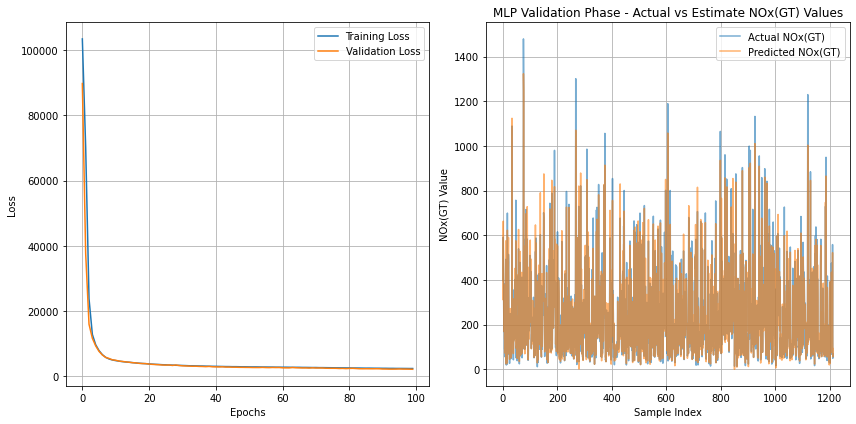

Table 4: Result table for the test data for the regression task.
 RMSE   MAE  Number of Samples
45.88 30.39               1214


In [27]:
# plot and performance
y_pred_reg_de = plot_pic_reg(history_reg_de.history, reg_model_de, X_test_scaled_reg_de, y_test_reg_de)
reg_performance(y_test_reg_de,y_pred_reg_de)

In [28]:
# imputation dataset for regression
X_train_scaled_reg = split_set_reg(dataset_im)[0]
X_test_scaled_reg = split_set_reg(dataset_im)[1]
y_train_reg = split_set_reg(dataset_im)[2]
y_test_reg = split_set_reg(dataset_im)[3]

result_reg_im = create_model_reg(X_train_scaled_reg,X_test_scaled_reg,y_train_reg,y_test_reg)
reg_model_im = result_reg_im[0]
history_reg_im = result_reg_im[1]


Epoch 1/100
209/209 [==============================] - 1s 1ms/step - loss: 91417.3750 - mae: 237.2040 - val_loss: 76870.1406 - val_mae: 213.9526
Epoch 2/100
209/209 [==============================] - 0s 891us/step - loss: 40221.7500 - mae: 148.9203 - val_loss: 19643.8281 - val_mae: 104.9173
Epoch 3/100
209/209 [==============================] - 0s 897us/step - loss: 14955.9932 - mae: 90.2617 - val_loss: 13270.9648 - val_mae: 83.7065
Epoch 4/100
209/209 [==============================] - 0s 902us/step - loss: 10493.2598 - mae: 74.6264 - val_loss: 9899.2959 - val_mae: 71.6013
Epoch 5/100
209/209 [==============================] - 0s 906us/step - loss: 8112.5176 - mae: 65.2323 - val_loss: 8110.9380 - val_mae: 65.5909
Epoch 6/100
209/209 [==============================] - 0s 882us/step - loss: 7025.6743 - mae: 60.7702 - val_loss: 7262.1538 - val_mae: 62.0610
Epoch 7/100
209/209 [==============================] - 0s 928us/step - loss: 6488.0806 - mae: 58.2799 - val_loss: 6794.7383 - val_mae

53/53 [==============================] - 0s 796us/step


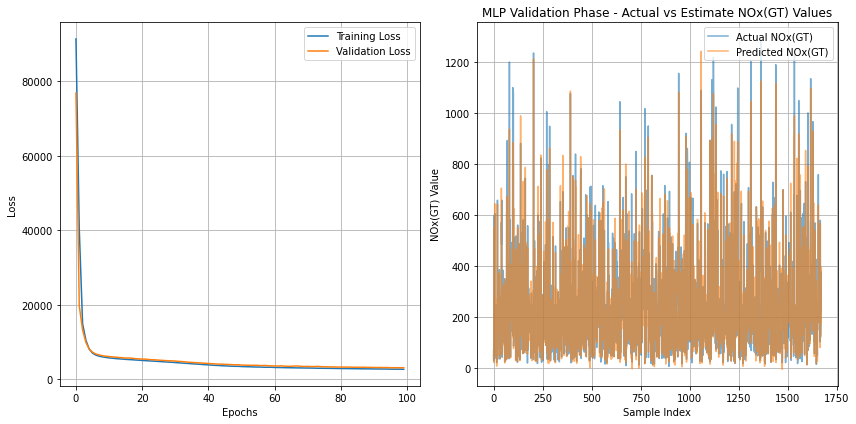

Table 4: Result table for the test data for the regression task.
 RMSE   MAE  Number of Samples
55.69 36.81               1672


In [29]:
# plot and performance
y_pred_reg_im = plot_pic_reg(history_reg_im.history,reg_model_im, X_test_scaled_reg, y_test_reg)
reg_performance(y_test_reg,y_pred_reg_im)

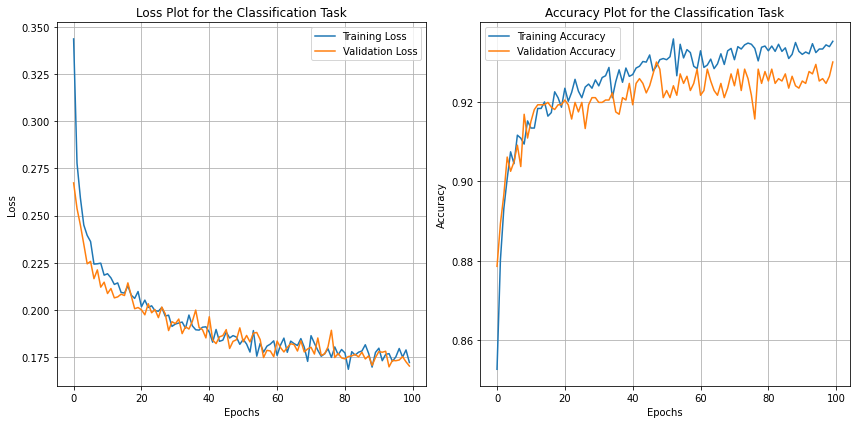

53/53 [==============================] - 0s 537us/step
Table 2: Confusion matrix for the test data for the classification task.
    Confusion Matrix  Positive (Actual)  Negative (Actual)
Positive (Predicted)                504                 76
Negative (Predicted)                 41               1051

Table 3: Accuracy and precision for the test data for the classification task.
                       Accuracy  Precision  Number of Samples
CO(GT) classification      0.93      0.925               1672


In [30]:
#save the model for classification
from keras.models import load_model
np.save('training_history_class.npy', history_class_im.history)
model_im_class.save('my_model_class.h5') 

# load model
loaded_history_class = np.load('training_history_class.npy', allow_pickle=True).item()
plot_pic_class(loaded_history_class)
model_load_class = load_model('my_model_class.h5')
model_performance(X_test_scaled, y_test, model_load_class)


53/53 [==============================] - 0s 538us/step


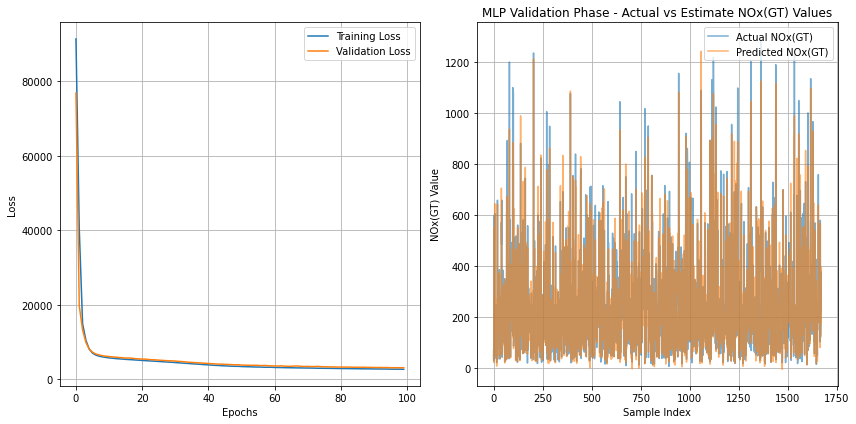

Table 4: Result table for the test data for the regression task.
 RMSE   MAE  Number of Samples
55.69 36.81               1672


In [31]:
# save the model for regression
np.save('training_history_regression.npy', history_reg_im.history)
reg_model_im.save('my_model_regression.h5') 

# load model
loaded_history_reg = np.load('training_history_regression.npy', allow_pickle=True).item()
model_load_reg = load_model('my_model_regression.h5')
plot_pic_reg(loaded_history_reg, model_load_reg, X_test_scaled_reg, y_test_reg)
reg_performance(y_test_reg, y_pred_reg_im)

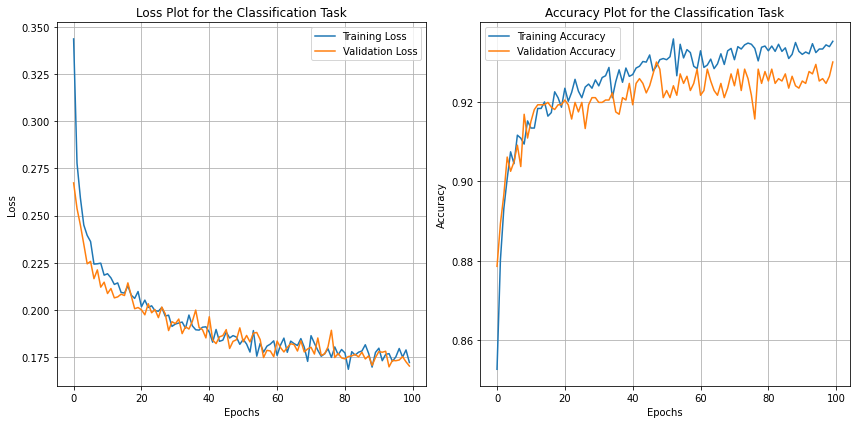

6/6 [==============================] - 0s 799us/step
Table 2: Confusion matrix for the test data for the classification task.
    Confusion Matrix  Positive (Actual)  Negative (Actual)
Positive (Predicted)                 60                  4
Negative (Predicted)                  5                106

Table 3: Accuracy and precision for the test data for the classification task.
                       Accuracy  Precision  Number of Samples
CO(GT) classification     0.949      0.923                175
6/6 [==============================] - 0s 501us/step


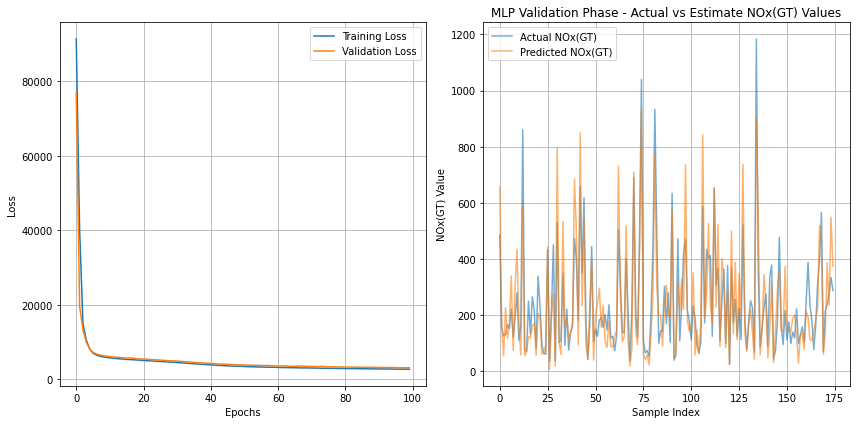

Table 4: Result table for the test data for the regression task.
  RMSE   MAE  Number of Samples
101.95 79.29                175


In [39]:
# for generalisation set
from keras.models import load_model
# read dataset and replace -200 by NaN
dataset_gen = pd.read_excel("Generalization Dataset.xlsx") # need to edit the path
dataset_gen.replace(-200, np.nan, inplace=True)
dataset_gen_im = imputation_pre(dataset_gen)


# load model classification
X_train_scaled_gen = split_set_classify(dataset_gen_im)[0]
X_test_scaled_gen = split_set_classify(dataset_gen_im)[1]
y_train_gen = split_set_classify(dataset_gen_im)[2]
y_test_gen = split_set_classify(dataset_gen_im)[3]
loaded_history_class_gen = np.load('training_history_class.npy', allow_pickle=True).item()
plot_pic_class(loaded_history_class_gen)
model_load_class_gen = load_model('my_model_class.h5')
model_performance(X_test_scaled_gen, y_test_gen, model_load_class_gen)

# load model regression
X_train_scaled_reg_gen = split_set_reg(dataset_gen_im)[0]
X_test_scaled_reg_gen = split_set_reg(dataset_gen_im)[1]
y_train_reg_gen = split_set_reg(dataset_gen_im)[2]
y_test_reg_gen = split_set_reg(dataset_gen_im)[3]
loaded_history_reg_gen = np.load('training_history_regression.npy', allow_pickle=True).item()
model_load_reg_gen = load_model('my_model_regression.h5')
y_pred_reg_gen = plot_pic_reg(loaded_history_reg_gen,model_load_reg_gen, X_test_scaled_reg_gen, y_test_reg_gen)
reg_performance(y_test_reg_gen, y_pred_reg_gen)
